## Семинар 15: "Обучение с подкреплением 2"

ФИО: Дорожинский Владислав Игоревич

###  FrozenLake


<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>



In [1]:
import gym
import numpy as np 
import random
import cv2
from torch import nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import deque
import time

In [ ]:
#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

In [2]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

## Задание 1.
Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake.

In [133]:

class QLearn:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        oldv = self.q.get((state, action), None)

        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state, is_eval=False):
        if random.random() < self.epsilon and not is_eval:
            action = random.choice(self.actions)
        else:
            q = [self.getQ(state, a) for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

In [134]:
def run_episode_qlearn_learn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        qlearn.learn(obs, action, reward, obs_new)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [136]:
def run_episode_qlearn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs, is_eval=True)
        obs_new, reward, done, _ = env.step(action)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [137]:
def evaluate_qlearn(env, qlearn, gamma=1.0, n=100):
    scores = [
            run_episode_qlearn(env, qlearn, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

In [168]:
GAMMA = 0.99
qlearn = QLearn(actions=range(env.env.nA), gamma=GAMMA, epsilon=0.1, alpha=0.3)
[run_episode_qlearn_learn(env, qlearn, gamma=GAMMA) for _ in range(1000)];


In [172]:
evaluate_qlearn(env, qlearn, gamma=1.0, n=1000)

0.759

## Задание 2.
Обучите сеть DQN для среды http://gym.openai.com/envs/Pong-v0/ 

* http://www.pinchofintelligence.com/introduction-openai-gym-part-2-building-deep-q-network/
* http://www.pinchofintelligence.com/openai-gym-part-3-playing-space-invaders-deep-reinforcement-learning/
* https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [2]:
env = gym.make('Pong-v0')
env.reset()
actions = env.action_space.n # 0 - idle, 4 - move up, 5 - move down

In [12]:
act_up, act_down, act_idle = 4, 5, 0
actions_mapping = [act_idle, act_up, act_down]

In [15]:
SHORT_MEMORY_SIZE = 4
N_ACTIONS = len(actions_mapping)
IMAGE_DIM = 84

Before processing: (210, 160, 3)


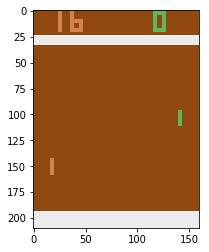

After processing: (84, 84, 1)


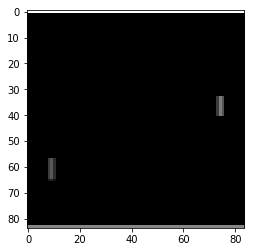

In [47]:
def one_hot(x, n_classes, dtype=np.float64):
    res = np.zeros([x.shape[0], n_classes], dtype=dtype)
    res[np.arange(x.shape[0]), x] = 1
    return res

def preprocess(observation):
    head_cut = 32
    tail_cut = 15
    target_size = IMAGE_DIM
    observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
    observation = cv2.resize(observation[head_cut:-tail_cut], (target_size, target_size))
#     ret, observation = cv2.threshold(observation,80,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(target_size,target_size,1))

def show(img):
    plt.imshow(np.array(np.squeeze(img)), cmap='gray')
    plt.show()

action0 = 0  # do nothing
observation0, reward0, terminal, info = env.step(action0)
print("Before processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(observation0))
plt.show()
observation0 = preprocess(observation0)
print("After processing: " + str(np.array(observation0).shape))
show(observation0)


In [62]:
class DQN(nn.Module):
    def __init__(self, in_channels, output_size):
        super(DQN, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels, 16, 8, stride=4),
                                      nn.BatchNorm2d(16),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 32, 4, stride=2),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(32 * 9 * 9, 256),
                                        nn.BatchNorm1d(256),
                                        nn.ReLU(),
                                        nn.Linear(256, output_size)
                                       )
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.features(x)
        x = x.view(-1, 32 * 9 * 9)
        x = -self.classifier(x)
        return x

In [63]:
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
M = 16
EXPLORE = 1000000 // M
REPLAY_MEMORY = 1000000 // M
BATCH_SIZE = 32 * M
PRINT_EVERY = 100
GAMMA = 0.9
ALPHA = 1.0
K = 4

class Controller:
    def __init__(self, verbose=False):
        self.epsilon = INITIAL_EPSILON
        self.verbose = verbose
        self.dqn = DQN(SHORT_MEMORY_SIZE, N_ACTIONS).cuda()
        self.optimizer = torch.optim.RMSprop(self.dqn.parameters(), lr=0.001)
        self.loss_f = nn.MSELoss()
        self.step = 0
        self.backshift = 0
        self.replay = deque()
        self.states = deque()
        
        self.cur_obs = np.zeros([IMAGE_DIM, IMAGE_DIM])
        
    def train_step(self):
        self.dqn.train()
        batch_idxs = np.random.randint(4, len(self.replay)-1, BATCH_SIZE)
        state_batch = np.zeros([BATCH_SIZE, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
        action_batch = np.zeros([BATCH_SIZE], dtype=np.int32)
        term_batch = np.zeros([BATCH_SIZE], dtype=np.int32)
        reward_batch = np.zeros([BATCH_SIZE], dtype=np.float32)
        y_reward_batch = np.zeros([BATCH_SIZE], dtype=np.float32)
        next_state_batch = np.zeros([BATCH_SIZE, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
        
        for i in range(BATCH_SIZE): # todo: vectorize
            idx = batch_idxs[i]
            action_batch[i] = self.replay[idx][1]
            reward_batch[i] = self.replay[idx][2]
            term_batch[i] = self.replay[idx][3]
            for j in range(SHORT_MEMORY_SIZE):
                state_batch[i,:,:,j] = self.states[idx - j]
                next_state_batch[i,:,:,j] = self.states[idx - j + 1]
        
        next_state_batch = Variable(torch.FloatTensor(next_state_batch)).cuda()
        reward_batch = torch.FloatTensor(reward_batch).cuda()
        term_batch = torch.FloatTensor(term_batch).cuda()
        q_values_pred = self.dqn(next_state_batch)
        q_values_pred = torch.max(q_values_pred, 1)[0].data
        y_reward_batch = reward_batch + q_values_pred * term_batch
        y_reward_batch = Variable(y_reward_batch)
                
        action_batch = one_hot(action_batch, N_ACTIONS)
        action_batch = torch.FloatTensor(action_batch).cuda()
        state_batch = Variable(torch.FloatTensor(state_batch)).cuda()
        
        q_values_pred = self.dqn(state_batch)
        q_act_vales = torch.sum(q_values_pred * action_batch, 1)
        loss = self.loss_f(q_act_vales, y_reward_batch)
        loss.backward()
        
        self.optimizer.step()
        self.dqn.zero_grad()
        
        if self.step % PRINT_EVERY == 0:
            rew_true = reward_batch.cpu().data.numpy()
            rew_true_mean = np.mean(rew_true)
            rew_true_stat = np.min(rew_true), np.max(rew_true)
            rew_true = (y_reward_batch.cpu().data.numpy() < -0.5)
            true_n = np.sum(rew_true)
            rew_pred = q_act_vales.cpu().data.numpy()
            rew_pred_mean = np.mean(rew_pred)
            rew_pred = (rew_pred < -0.5)
            pred_n = np.sum(rew_pred)
            hit_n = np.sum(rew_true & (rew_pred == rew_true))
            res_str = '[{}] Loss: {:.4f} TrueN: {} PredN: {} HitNegN: {} PredRew: {:.4f} ActRew: {:.4f} Eps: {:.3f}'
            print(res_str.format(self.step,
                                 loss.item(),
                                 true_n,
                                 pred_n,
                                 hit_n,
                                 rew_pred_mean,
                                 rew_true_mean,
                                 self.epsilon
                                ))

            
        
    def get_action(self):
        action = -1
        if random.random() <= self.epsilon or len(self.states) < SHORT_MEMORY_SIZE:
            action = np.random.randint(N_ACTIONS)
        else:
            state_batch = np.zeros([1, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
            idx = len(self.states) - 1
            for j in range(SHORT_MEMORY_SIZE):
                state_batch[0,:,:,j] = self.states[idx - j]
            state_batch = Variable(torch.FloatTensor(state_batch)).cuda()
            self.dqn.eval()
            qs = self.dqn(state_batch).cpu().data.numpy()[0]
            action = np.argmax(qs)
        
        self.epsilon = INITIAL_EPSILON - (INITIAL_EPSILON - FINAL_EPSILON) \
            * self.step / EXPLORE if self.epsilon > FINAL_EPSILON else FINAL_EPSILON
        
        return action
    
    def observe(self, new_obs, action, reward, is_terminal):
        self.replay.append((self.step, action, reward, is_terminal))
        self.states.append(self.cur_obs)
        if len(self.replay) > REPLAY_MEMORY: 
            self.replay.popleft()
            self.states.popleft()
        if self.step > SHORT_MEMORY_SIZE:
            self.train_step()
        
        self.cur_obs = new_obs
        self.step += 1

In [64]:
ctrl = Controller()
env.reset();

In [65]:
actionmax = 0
for e in range(10000000):
    if e % K == 0:
        action = ctrl.get_action()
        actionmax = np.argmax(np.array(action))
    
    new_obs, reward, is_term, _ = env.step(actionmax)
    if is_term:
        new_obs = env.reset()
    if e % K == 0:
        new_obs = preprocess(new_obs).squeeze()
        ctrl.observe(new_obs, action, reward, is_term)

[100] Loss: 0.0006 TrueN: 16 PredN: 16 HitNegN: 16 PredRew: -0.0343 ActRew: -0.0312 Eps: 0.999
[200] Loss: 0.0011 TrueN: 13 PredN: 13 HitNegN: 13 PredRew: -0.0340 ActRew: -0.0254 Eps: 0.997
[300] Loss: 0.0059 TrueN: 15 PredN: 13 HitNegN: 13 PredRew: -0.0214 ActRew: -0.0293 Eps: 0.996
[400] Loss: 0.0017 TrueN: 14 PredN: 15 HitNegN: 14 PredRew: -0.0314 ActRew: -0.0273 Eps: 0.994
[500] Loss: 0.0029 TrueN: 9 PredN: 10 HitNegN: 9 PredRew: -0.0270 ActRew: -0.0176 Eps: 0.993
[600] Loss: 0.0010 TrueN: 14 PredN: 14 HitNegN: 14 PredRew: -0.0317 ActRew: -0.0273 Eps: 0.991
[700] Loss: 0.0011 TrueN: 10 PredN: 10 HitNegN: 10 PredRew: -0.0341 ActRew: -0.0195 Eps: 0.990
[800] Loss: 0.0021 TrueN: 12 PredN: 12 HitNegN: 12 PredRew: -0.0033 ActRew: -0.0234 Eps: 0.988
[900] Loss: 0.0026 TrueN: 10 PredN: 8 HitNegN: 8 PredRew: -0.0155 ActRew: -0.0195 Eps: 0.987
[1000] Loss: 0.0016 TrueN: 13 PredN: 12 HitNegN: 12 PredRew: -0.0039 ActRew: -0.0254 Eps: 0.986
[1100] Loss: 0.0006 TrueN: 12 PredN: 12 HitNegN: 12 P

[8800] Loss: 0.0001 TrueN: 6 PredN: 6 HitNegN: 6 PredRew: -0.0143 ActRew: -0.0117 Eps: 0.873
[8900] Loss: 0.0005 TrueN: 11 PredN: 11 HitNegN: 11 PredRew: -0.0254 ActRew: -0.0215 Eps: 0.872
[9000] Loss: 0.0009 TrueN: 9 PredN: 9 HitNegN: 9 PredRew: -0.0187 ActRew: -0.0176 Eps: 0.870


KeyboardInterrupt: 

In [152]:
obs = env.reset()

Reward: 0.0, terminal?: False


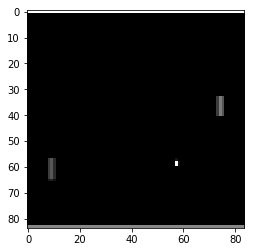

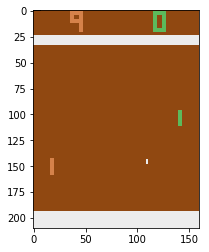

In [93]:
act = act_idle
# act = act_up
# act = act_down
obs, reward, is_term, _ = env.step(act)
print('Reward: {}, terminal?: {}'.format(reward, is_term))
show(preprocess(obs))
show(obs)

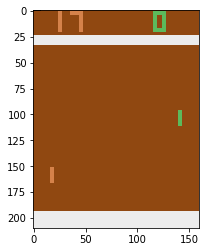

In [185]:
show(obs)